<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Prepare-the-coefficients" data-toc-modified-id="Prepare-the-coefficients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare the coefficients</a></span></li><li><span><a href="#Compute-the-robust-controllable-sets" data-toc-modified-id="Compute-the-robust-controllable-sets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Compute the robust controllable sets</a></span></li></ul></div>

# Introduction
This script computes the robust controllable sets for a random
geometric path. Several values of the bound on perturbations' norm are
consider:

1. R = 0, Ideal case.
2. R = 1, Medium uncertainty.
3. R = 2, High uncertainty.
3. R = 7, Very High uncertainty.

In [1]:
# Setup
import numpy as np
import openravepy as orpy
import toppra as ta
import matplotlib.pyplot as plt
import following_lib as fo

# Setup logging for toppra
import coloredlogs
coloredlogs.install(level='DEBUG')
np.set_printoptions(5)

# Setup the robot, the geometric path and the torque bounds
env = orpy.Environment()
env.Load('/home/hung/git/robotic-CRI/rave/denso_vs060.dae')
robot = env.GetRobots()[0]
np.random.seed(11)
waypoints = np.random.randn(5, 6) * 0.4
path = ta.SplineInterpolator(np.linspace(0, 1, 5), waypoints)
tau_max = np.r_[30., 50., 20., 20., 10., 10.]
robot.SetDOFTorqueLimits(tau_max)
tau_min = - tau_max

# Prepare the coefficients
The below cell prepares the coefficients of the constraints, all of which are encapsulated
in the class `RobustPathConstraint`.

Specifically, suppose there are N+1 stages: $$(s_0, ..., s_N)$$
At stage i, there are m constraints. The j-th constraint is given by
$$
 a_{ij} u + b_{ij} x + c_{ij} + w_i \left\|P_{ij} \begin{bmatrix}u \\ x \\ 1 \end{bmatrix}\right\| \leq 0
$$
The `RobustPathConstraint` class accepts as its input a tensor $v$ such that
$$
v_{ij0} = a_{ij}, v_{ij1} = b_{ij}, v_{ij2} = c_{ij}
$$
the tensor $P$ and the vector $s$.

The floats $w_i, i\in [0, \dots, N]$ are given during computations of the robust controllablet
sets.

In [11]:
# Nominal case
N = 100
ss = np.linspace(0, 1, N + 1)
cnst = ta.create_rave_torque_path_constraint(
    path, np.linspace(0, 1, N + 1), robot)
cnst_intp = ta.interpolate_constraint(cnst)
pp = ta.qpOASESPPSolver([cnst_intp])
pp.set_goal_interval([0, 1e-3])
pp.solve_controllable_sets()
Ks = pp.K
# Robust Path Constraint
vs = np.zeros((N + 1, 12, 3))
Ps = np.zeros((N + 1, 12, 3, 3))
vs[:, :, 0] = cnst.a
vs[:, :, 1] = cnst.b
vs[:, :, 2] = cnst.c
Ps[:, :] = np.eye(3)

robust_cnst = fo.RobustPathConstraint(vs, Ps, ss)

2018-05-12 18:10:14 hung-asus toppra.constraints[19776] INFO Torque bounds for OpenRAVE robot generated.
2018-05-12 18:10:14 hung-asus toppra.TOPP[19776] INFO 
Initialize Path Parameterization instance
------------------------------
	 N                  :      100
	 No. of constraints :        1
	 No. of slack var   :        0
	 No. of can. ineq.  :       24
	 No. of equalities  :        0
	 No. of inequalities:        0

2018-05-12 18:10:14 hung-asus toppra.TOPP[19776] DEBUG Set qpOASES print level to NONE


# Compute the robust controllable sets

The sets are computed for three different values of R: 0, 1 and 3.

In [12]:
Ks_low = np.ones((N + 1, 2))  # Robust controllable sets
Ks_low[N] = [0, 1e-3]
for i in range(N - 1, -1, -1):
    Ks_low[i] = fo.robust_one_step(robust_cnst, i, Ks_low[i + 1], 1, 1, method='ECOS')

Ks_high = np.ones((N + 1, 2))  # Robust controllable sets
Ks_high[N] = [0, 1e-3]
for i in range(N - 1, -1, -1):
    Ks_high[i] = fo.robust_one_step(robust_cnst, i, Ks_high[i + 1],
                                    3, 3, method='ECOS')
    
Ks_high2 = np.ones((N + 1, 2))  # Robust controllable sets
Ks_high2[N] = [0, 1e-3]
for i in range(N - 1, -1, -1):
    Ks_high2[i] = fo.robust_one_step(robust_cnst, i, Ks_high2[i + 1],
                                    7, 7, method='ECOS')

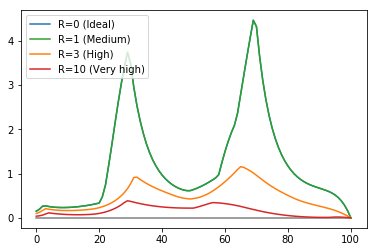

In [14]:
# PLotting
f, ax = plt.subplots(figsize=[6.2, 4])
ax.plot(pp.K[:, 1], label='R=0 (Ideal)', color='C0')
ax.plot(pp.K[:, 0], color='gray')
ax.plot(Ks[:, 1], label='R=1 (Medium)', color='C2')
ax.plot(Ks_high[:, 1], label='R=3 (High)', color='C1')
ax.plot(Ks_high2[:, 1], label='R=10 (Very high)', color='C3')
ax.legend()
# plt.savefig('/home/hung/git/hung/Papers/2017-TOPP-following/figures/compare_robust_ctrl_sets.pdf')
plt.show()

Several things to observe:
- The robust controllable sets corresponding to higher perturbations are strictly smaller;
- Key differences are seen during deccelerating segments;
- At very high level of uncertainty, the set of robust controllable states might be empty (see red lines).

Some questions:
- How to select a good value for R? Of course hand-tuning is a possible choice.